# Imports

In [4]:
import sys
sys.path.append('..')

In [82]:
# analysis
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.base import clone
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import h5py

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# local
import alignment.alignment_utils as utils
from alignment.AlignCCA import AlignCCA
from processing_utils.poisson_disk_sampling import pitch_subsample_sig_channels
from processing_utils.grid_subsampling import grid_subsample_sig_channels
from processing_utils.spatial_avg_subsampling import spatial_avg_channels, spatial_avg_data

%matplotlib inline

In [6]:
def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# Data Loading

In [144]:
DECODE_PATH = '../data/results/decoding/'

### Real data

In [7]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [8]:
DATA_PATH = '../data/'
# data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl' # mean-subtracted
data_filename = DATA_PATH + 'pt_decoding_data_S62_zscore.pkl' # z-scored

In [9]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [10]:
pt_artic_maps = {}
for pt in pt_names:
    h5_fname = f'../data/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5'
    with h5py.File(h5_fname, 'r') as f:
        weights = f['weights'][()]
        weight_map = f['weight_map'][()]
    pt_artic_maps[pt] = {}
    pt_artic_maps[pt]['weights'] = weights
    pt_artic_maps[pt]['weight_map'] = weight_map

In [11]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [12]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

## Phoneme label processing functions

In [13]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [14]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [15]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [16]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

# Data Visualization

### Utils

In [152]:
px_colors = px.colors.qualitative.Plotly

In [153]:
# sns.set_theme(context='notebook', font='Arial', font_scale=1.15)
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [19]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    cbar.outline.set_visible(False)

    sns.despine(left=True, bottom=True)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [21]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [22]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

In [23]:
def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25, t_range=[-0.25, 0.25]):
    min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
    # get data only around speech onset
    t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
    target = target[:, t_inds]
    to_corr = to_corr[:, t_inds]
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    n_cnds = cnd_avg_data[0].shape[0]
    cnd_r = np.zeros(n_cnds)
    for i in range(cnd_avg_data[0].shape[0]):
        target_avg = cnd_avg_data[0][i,:,:min_dim]
        to_corr_avg = cnd_avg_data[1][i,:,:min_dim]

        r_vals = np.zeros(min_dim)
        for j in range(min_dim):
            r_vals[j] = stats.pearsonr(target_avg[:,j], to_corr_avg[:,j])[0]
        cnd_r[i] = np.mean(r_vals)
    return cnd_r

def pt_corr_multi(target, to_corr_list, target_labels, to_corr_labels_list, n_comp=25, t_range=[-0.25, 0.25]):
    cnd_r = []
    for i, to_corr in enumerate(to_corr_list):
        cnd_r.append(pt_corr(target, to_corr, target_labels, to_corr_labels_list[i], n_comp=n_comp, t_range=t_range))
    return cnd_r

In [141]:
def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

### Panel a

#### Cross-patient correlation

In [53]:
pitch_corr_tot_df = pd.DataFrame()
for align_pt in pt_names:
    print(f'##### Aligning to {align_pt} ({paper_pt_dict[align_pt]}) #####')
    align_pt_ind = pt_names.index(align_pt)
    other_pts = [pt for pt in pt_names if pt != align_pt]

    n_iter = 50
    n_comp_corr = 10

    pitch_corr_df = pd.DataFrame()
    pitch_list = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1.5]

    for pitch in pitch_list:
        print(f'Pitch {pitch}')
        for iter in tqdm(range(n_iter)):

            # subsample all patient data with poisson disk sampling
            all_pt_traces_sub = {}
            for pt in pt_names:
                subsamp_idx = pitch_subsample_sig_channels(pt, pitch, DATA_PATH)
                all_pt_traces_sub[pt] = all_pt_traces[pt][:,:,subsamp_idx]

            # setup CCA aligners for each condition and patient
            aligners_sub = {}
            for i, pt in enumerate(pt_names):
                if i == align_pt_ind:
                    continue
                aligners_sub[pt] = AlignCCA()

            # get patient-specific latent dynamics with PCA on channels
            to_align_sub = [PCA(n_components=0.9).fit_transform(all_pt_traces_sub[pt].reshape(-1, all_pt_traces_sub[pt].shape[-1])) for pt in pt_names]
            to_align_sub = [to_align_sub[i].reshape(all_pt_traces_sub[pt].shape[0], all_pt_traces_sub[pt].shape[1], -1) for i, pt in enumerate(pt_names)]

            # align patient-specific latent dynamics
            aligned_data_sub = {}

            # aligning all patients to a single patient's space, so the align patient's latent dynamics are un-transformed
            aligned_data_sub[pt_names[align_pt_ind]] = to_align_sub[align_pt_ind]
            for i, pt in enumerate(pt_names):
                if i == align_pt_ind:
                    continue
                
                # align by phoneme sequence
                to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
                aligners_sub[pt].fit(to_align_sub[align_pt_ind], to_align_sub[i], to_align_seqs[0], to_align_seqs[1])
                aligned_data_sub[pt] = aligners_sub[pt].transform(to_align_sub[i])

            align_corrs_sub = pt_corr_multi(aligned_data_sub[align_pt], [aligned_data_sub[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
            
            corr = np.mean(np.array(align_corrs_sub))
            curr_pitch_df = pd.DataFrame([{'Pitch': pitch, 'Correlation': corr}])
            pitch_corr_df = pd.concat([pitch_corr_df, curr_pitch_df], ignore_index=True)

    pitch_corr_df['Patient'] = paper_pt_dict[align_pt]
    pitch_corr_df = pitch_corr_df[['Patient', 'Pitch', 'Correlation']]
    pitch_corr_tot_df = pd.concat([pitch_corr_tot_df, pitch_corr_df], ignore_index=True)


##### Aligning to S14 (S1) #####
Pitch 10


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Pitch 9


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


Pitch 8


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Pitch 7


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Pitch 6


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Pitch 5


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Pitch 4


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Pitch 3


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Pitch 2


100%|██████████| 50/50 [07:04<00:00,  8.49s/it]


Pitch 1.5


100%|██████████| 50/50 [03:25<00:00,  4.10s/it]


##### Aligning to S26 (S2) #####
Pitch 10


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


Pitch 9


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Pitch 8


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Pitch 7


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Pitch 6


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Pitch 5


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Pitch 4


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Pitch 3


100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Pitch 2


100%|██████████| 50/50 [06:39<00:00,  7.99s/it]


Pitch 1.5


100%|██████████| 50/50 [03:16<00:00,  3.93s/it]


##### Aligning to S23 (S5) #####
Pitch 10


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]


Pitch 9


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Pitch 8


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Pitch 7


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Pitch 6


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Pitch 5


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Pitch 4


100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


Pitch 3


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Pitch 2


100%|██████████| 50/50 [06:30<00:00,  7.82s/it]


Pitch 1.5


100%|██████████| 50/50 [03:07<00:00,  3.75s/it]


##### Aligning to S33 (S3) #####
Pitch 10


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Pitch 9


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Pitch 8


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Pitch 7


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Pitch 6


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Pitch 5


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Pitch 4


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Pitch 3


100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


Pitch 2


100%|██████████| 50/50 [06:45<00:00,  8.12s/it]


Pitch 1.5


100%|██████████| 50/50 [03:29<00:00,  4.20s/it]


##### Aligning to S22 (S4) #####
Pitch 10


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


Pitch 9


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Pitch 8


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Pitch 7


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


Pitch 6


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


Pitch 5


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Pitch 4


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Pitch 3


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Pitch 2


100%|██████████| 50/50 [06:27<00:00,  7.75s/it]


Pitch 1.5


100%|██████████| 50/50 [03:14<00:00,  3.88s/it]


##### Aligning to S39 (S6) #####
Pitch 10


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Pitch 9


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Pitch 8


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Pitch 7


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Pitch 6


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


Pitch 5


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Pitch 4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Pitch 3


100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


Pitch 2


100%|██████████| 50/50 [06:42<00:00,  8.06s/it]


Pitch 1.5


100%|██████████| 50/50 [03:32<00:00,  4.25s/it]


##### Aligning to S58 (S7) #####
Pitch 10


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Pitch 9


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Pitch 8


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Pitch 7


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Pitch 6


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Pitch 5


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Pitch 4


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


Pitch 3


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


Pitch 2


100%|██████████| 50/50 [06:50<00:00,  8.21s/it]


Pitch 1.5


100%|██████████| 50/50 [03:36<00:00,  4.33s/it]


##### Aligning to S62 (S8) #####
Pitch 10


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Pitch 9


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Pitch 8


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


Pitch 7


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


Pitch 6


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


Pitch 5


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Pitch 4


100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


Pitch 3


100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Pitch 2


100%|██████████| 50/50 [06:54<00:00,  8.28s/it]


Pitch 1.5


100%|██████████| 50/50 [04:01<00:00,  4.84s/it]


In [55]:
pitch_corr_tot_df

,Patient,Pitch,Correlation
0,S1,10.0,0.287959
1,S1,10.0,0.312267
2,S1,10.0,0.327200
3,S1,10.0,0.330463
4,S1,10.0,0.368184
...,...,...,...
3995,S8,1.5,0.566085
3996,S8,1.5,0.566034
3997,S8,1.5,0.563809
3998,S8,1.5,0.570201


In [63]:
mean_pitch_corr_df = pitch_corr_tot_df.groupby(['Patient', 'Pitch']).mean().reset_index()
mean_pitch_corr_df

,Patient,Pitch,Correlation
0,S1,1.5,0.433565
1,S1,2.0,0.392558
2,S1,3.0,0.331098
3,S1,4.0,0.289454
4,S1,5.0,0.280066
...,...,...,...
75,S8,6.0,0.250285
76,S8,7.0,0.226910
77,S8,8.0,0.238730
78,S8,9.0,0.224015


In [208]:
fig = px.line(mean_pitch_corr_df, x='Pitch', y="Correlation", color='Patient', width=700, height=500)
fig.add_traces(px.box(mean_pitch_corr_df, x='Pitch', y="Correlation").data)

fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    title_text=f'Pitch-subsampled cross-patient correlation',
    title_x=0.5,
    font=dict(size=18, family='Arial'),
)
fig.update_xaxes(
    title='Effective Pitch (mm)',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    autorange='reversed',
    tickvals=pitch_list,
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.025, 0.75]
)

# fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\pitch_subsamp_corr.svg")
fig.show()

#### Cross-patient decoding

In [163]:
pt_list = ['S14', 'S22', 'S23', 'S26', 'S33', 'S39', 'S58', 'S62']

pInd_list = [-1]

pitch_list = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1.5]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        for pitch in pitch_list:
            if pitch == 1.5:
                pitch_str = '1-5'
            else:
                pitch_str = str(int(pitch))

            p_tar = np.zeros((2, 50))
            p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'ptSpecific/{pt}/pitch_subsampling/{pt}_{p_str}_pitchSubsamp{pitch_str}mm_ptSpecific_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'pooled/S62_added/{pt}/pitch_subsampling/cca/{pt}_{p_str}_pitchSubsamp{pitch_str}mm_pooled_ccaAligned_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific', 'Aligned cross-patient'])

            wide_dfs.append(decode_df)
            decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='Decoding Accuracy')
            decode_df['Patient'] = paper_pt_dict[pt]
            decode_df['Phoneme Index'] = p_str
            decode_df['Pitch'] = pitch
            cols = decode_df.columns.tolist()
            cols = cols[-2:] + cols[:-2]
            decode_df = decode_df[cols]
            long_dfs.append(decode_df)
pitch_decode_df_wide = pd.concat(wide_dfs)
pitch_decode_df_long = pd.concat(long_dfs)
pitch_decode_df_long = pitch_decode_df_long.sort_values(by=['Pitch', 'Decoding Context'], ascending=[False, True])


In [164]:
pitch_decode_df_long

,Phoneme Index,Pitch,Decoding Context,Decoding Accuracy,Patient
50,pAll,10.0,Aligned cross-patient,0.185185,S1
51,pAll,10.0,Aligned cross-patient,0.150463,S1
52,pAll,10.0,Aligned cross-patient,0.166667,S1
53,pAll,10.0,Aligned cross-patient,0.182870,S1
54,pAll,10.0,Aligned cross-patient,0.097222,S1
...,...,...,...,...,...
45,pAll,1.5,Patient-specific,0.286517,S8
46,pAll,1.5,Patient-specific,0.310861,S8
47,pAll,1.5,Patient-specific,0.286517,S8
48,pAll,1.5,Patient-specific,0.299625,S8


In [165]:
mean_pitch_decode_df = pitch_decode_df_long.drop(columns=['Phoneme Index']).groupby(['Patient', 'Pitch', 'Decoding Context']).mean().reset_index()
mean_pitch_decode_df

,Patient,Pitch,Decoding Context,Decoding Accuracy
0,S1,1.5,Aligned cross-patient,0.397130
1,S1,1.5,Patient-specific,0.384954
2,S1,2.0,Aligned cross-patient,0.365787
3,S1,2.0,Patient-specific,0.363241
4,S1,3.0,Aligned cross-patient,0.283472
...,...,...,...,...
155,S8,8.0,Patient-specific,0.172809
156,S8,9.0,Aligned cross-patient,0.151461
157,S8,9.0,Patient-specific,0.162959
158,S8,10.0,Aligned cross-patient,0.143109


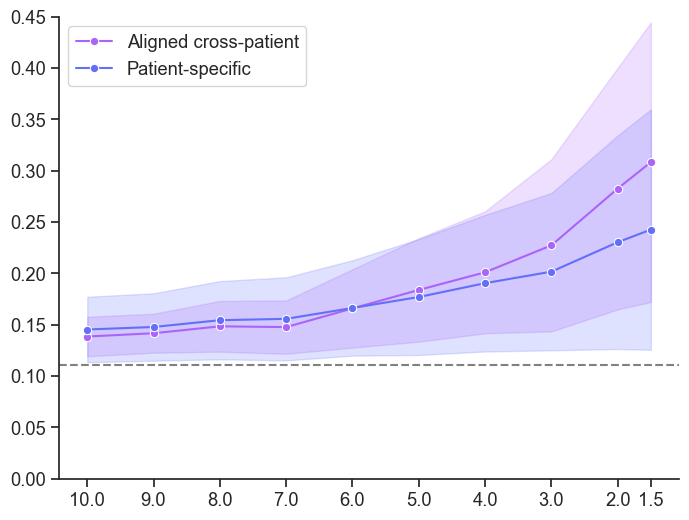

In [166]:
f, ax1 = plt.subplots(1,1, figsize=(8,6))
# sns.lineplot(data=pitch_decode_df_long, x='Pitch', y='Decoding Accuracy', hue='Decoding Context', marker='o', errorbar='sd', palette=[px_colors[3], px_colors[0]])
sns.lineplot(data=mean_pitch_decode_df, x='Pitch', y='Decoding Accuracy', hue='Decoding Context', marker='o', errorbar='sd', palette=[px_colors[3], px_colors[0]])
ax1.invert_xaxis()
ax1.set_xticks(pitch_list)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axhline(1/9, color='grey', linestyle='--')
# ax1.set_title('Decoding Accuracy by Pitch')
ax1.set_ylim(0.05, 0.45)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 0.45)

sns.despine()
plt.savefig(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\pitch_subsamp_decode.svg")
plt.show()

### Panel b

#### Cross-patient correlation

In [61]:
grid_corr_tot_df = pd.DataFrame()
for align_pt in pt_names:
    print(f'##### Aligning to {align_pt} ({paper_pt_dict[align_pt]}) #####')
    # align_pt = 'S14'
    align_pt_ind = pt_names.index(align_pt)
    other_pts = [pt for pt in pt_names if pt != align_pt]

    n_comp_corr = 10

    grid_corr_df = pd.DataFrame()

    grid_list = [(2,4), (3,6), (4,8), (5,10), (6,12), (7,14), (8,16)]
    grid_list_str = [f'{x[0]}x{x[1]}' for x in grid_list]

    for grid, grid_str in zip(grid_list, grid_list_str):
        print(f'Grid Size: {grid_str}')
        all_pt_idxs_sub = {}
        for pt in pt_names:

            all_pt_idxs_sub[pt] = []

            # subsample grids from all patient data
            subsamp_idxs = grid_subsample_sig_channels(pt, grid, DATA_PATH)

            # save idxs for all subsample grid locations for each patient
            for sub_idx in subsamp_idxs:
                all_pt_idxs_sub[pt].append(sub_idx)

        # iterate over all grid subsamples for the patient we're aligning to and
        # get the data from the selected subsample channels
        for i in tqdm(range(len(all_pt_idxs_sub[align_pt]))):
            sub_grid = all_pt_idxs_sub[align_pt][i]
            all_pt_traces_sub = {}
            all_pt_traces_sub[align_pt] = all_pt_traces[align_pt][:,:,sub_grid]

            # select a random grid subsample for each other patient
            for cross_pt in other_pts:
                rand_idx = np.random.choice(len(all_pt_idxs_sub[cross_pt]))
                sub_grid_cross = all_pt_idxs_sub[cross_pt][rand_idx]
                all_pt_traces_sub[cross_pt] = all_pt_traces[cross_pt][:,:,sub_grid_cross]

            # setup CCA aligners for each condition and patient
            aligners_sub = {}
            for i, pt in enumerate(pt_names):
                if i == align_pt_ind:
                    continue
                aligners_sub[pt] = AlignCCA()

            # get patient-specific latent dynamics with PCA on channels
            to_align_sub = [PCA(n_components=0.9).fit_transform(all_pt_traces_sub[pt].reshape(-1, all_pt_traces_sub[pt].shape[-1])) for pt in pt_names]
            to_align_sub = [to_align_sub[i].reshape(all_pt_traces_sub[pt].shape[0], all_pt_traces_sub[pt].shape[1], -1) for i, pt in enumerate(pt_names)]

            # align patient-specific latent dynamics
            aligned_data_sub = {}
            aligned_data_sub[pt_names[align_pt_ind]] = to_align_sub[align_pt_ind]
            for i, pt in enumerate(pt_names):
                if i == align_pt_ind:
                    continue
                
                # align by phoneme sequence
                to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
                aligners_sub[pt].fit(to_align_sub[align_pt_ind], to_align_sub[i], to_align_seqs[0], to_align_seqs[1])
                aligned_data_sub[pt] = aligners_sub[pt].transform(to_align_sub[i])

            align_corrs_sub = pt_corr_multi(aligned_data_sub[align_pt], [aligned_data_sub[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
            
            corr = np.mean(np.array(align_corrs_sub))
            curr_grid_df = pd.DataFrame([{'Grid Size': grid_str, 'Correlation': corr}])
            grid_corr_df = pd.concat([grid_corr_df, curr_grid_df], ignore_index=True)

    grid_corr_df['Patient'] = paper_pt_dict[align_pt]
    grid_corr_df = grid_corr_df[['Patient', 'Grid Size', 'Correlation']]
    grid_corr_tot_df = pd.concat([grid_corr_tot_df, grid_corr_df], ignore_index=True)


##### Aligning to S14 (S1) #####
Grid Size: 2x4


100%|██████████| 91/91 [00:30<00:00,  2.96it/s]


Grid Size: 3x6


100%|██████████| 66/66 [00:39<00:00,  1.66it/s]


Grid Size: 4x8


100%|██████████| 45/45 [00:31<00:00,  1.41it/s]


Grid Size: 5x10


100%|██████████| 28/28 [00:23<00:00,  1.17it/s]


Grid Size: 6x12


100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Grid Size: 7x14


100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Grid Size: 8x16


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


##### Aligning to S26 (S2) #####
Grid Size: 2x4


100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


Grid Size: 3x6


100%|██████████| 66/66 [00:32<00:00,  2.01it/s]


Grid Size: 4x8


100%|██████████| 45/45 [00:33<00:00,  1.34it/s]


Grid Size: 5x10


100%|██████████| 28/28 [00:23<00:00,  1.17it/s]


Grid Size: 6x12


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


Grid Size: 7x14


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Grid Size: 8x16


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


##### Aligning to S23 (S5) #####
Grid Size: 2x4


100%|██████████| 89/89 [00:23<00:00,  3.76it/s]


Grid Size: 3x6


100%|██████████| 66/66 [00:29<00:00,  2.26it/s]


Grid Size: 4x8


100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


Grid Size: 5x10


100%|██████████| 28/28 [00:24<00:00,  1.15it/s]


Grid Size: 6x12


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Grid Size: 7x14


100%|██████████| 6/6 [00:07<00:00,  1.20s/it]


Grid Size: 8x16


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


##### Aligning to S33 (S3) #####
Grid Size: 2x4


100%|██████████| 164/164 [00:50<00:00,  3.24it/s]


Grid Size: 3x6


100%|██████████| 147/147 [01:09<00:00,  2.11it/s]


Grid Size: 4x8


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Grid Size: 5x10


100%|██████████| 101/101 [01:24<00:00,  1.19it/s]


Grid Size: 6x12


100%|██████████| 77/77 [01:21<00:00,  1.05s/it]


Grid Size: 7x14


100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Grid Size: 8x16


100%|██████████| 35/35 [00:49<00:00,  1.40s/it]


##### Aligning to S22 (S4) #####
Grid Size: 2x4


100%|██████████| 73/73 [00:23<00:00,  3.06it/s]


Grid Size: 3x6


100%|██████████| 62/62 [00:30<00:00,  2.03it/s]


Grid Size: 4x8


100%|██████████| 45/45 [00:33<00:00,  1.36it/s]


Grid Size: 5x10


100%|██████████| 28/28 [00:23<00:00,  1.17it/s]


Grid Size: 6x12


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Grid Size: 7x14


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Grid Size: 8x16


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


##### Aligning to S39 (S6) #####
Grid Size: 2x4


100%|██████████| 179/179 [01:18<00:00,  2.28it/s]


Grid Size: 3x6


100%|██████████| 164/164 [01:26<00:00,  1.89it/s]


Grid Size: 4x8


100%|██████████| 134/134 [01:31<00:00,  1.47it/s]


Grid Size: 5x10


100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


Grid Size: 6x12


100%|██████████| 77/77 [01:22<00:00,  1.07s/it]


Grid Size: 7x14


100%|██████████| 54/54 [01:06<00:00,  1.24s/it]


Grid Size: 8x16


100%|██████████| 35/35 [00:54<00:00,  1.57s/it]


##### Aligning to S58 (S7) #####
Grid Size: 2x4


100%|██████████| 208/208 [01:01<00:00,  3.36it/s]


Grid Size: 3x6


100%|██████████| 170/170 [01:31<00:00,  1.86it/s]


Grid Size: 4x8


100%|██████████| 135/135 [01:38<00:00,  1.36it/s]


Grid Size: 5x10


100%|██████████| 104/104 [01:30<00:00,  1.15it/s]


Grid Size: 6x12


100%|██████████| 77/77 [01:19<00:00,  1.04s/it]


Grid Size: 7x14


100%|██████████| 54/54 [01:11<00:00,  1.32s/it]


Grid Size: 8x16


100%|██████████| 35/35 [00:51<00:00,  1.47s/it]


##### Aligning to S62 (S8) #####
Grid Size: 2x4


100%|██████████| 207/207 [01:09<00:00,  2.98it/s]


Grid Size: 3x6


100%|██████████| 170/170 [01:43<00:00,  1.64it/s]


Grid Size: 4x8


100%|██████████| 135/135 [01:43<00:00,  1.30it/s]


Grid Size: 5x10


100%|██████████| 104/104 [01:39<00:00,  1.05it/s]


Grid Size: 6x12


100%|██████████| 77/77 [01:29<00:00,  1.16s/it]


Grid Size: 7x14


100%|██████████| 54/54 [01:17<00:00,  1.43s/it]


Grid Size: 8x16


100%|██████████| 35/35 [00:54<00:00,  1.56s/it]


In [68]:
grid_corr_tot_df

,Patient,Grid Size,Correlation
0,S1,2x4,0.138889
1,S1,2x4,0.317195
2,S1,2x4,0.235517
3,S1,2x4,0.136548
4,S1,2x4,0.130715
...,...,...,...
3993,S8,8x16,0.499152
3994,S8,8x16,0.482569
3995,S8,8x16,0.472928
3996,S8,8x16,0.447301


In [69]:
mean_grid_corr_df = grid_corr_tot_df.groupby(['Patient', 'Grid Size']).mean().reset_index()
mean_grid_corr_df

,Patient,Grid Size,Correlation
0,S1,2x4,0.194270
1,S1,3x6,0.229865
2,S1,4x8,0.280067
3,S1,5x10,0.320952
4,S1,6x12,0.346023
5,S1,7x14,0.358015
6,S1,8x16,0.408755
7,S2,2x4,0.269564
8,S2,3x6,0.279925
9,S2,4x8,0.326176


In [207]:
med_grid_df = mean_grid_corr_df.groupby(['Grid Size', 'Patient']).median().reset_index()
# fig = px.line(med_grid_df, x='Grid Size', y="Correlation", width=800, height=500)
fig = px.line(mean_grid_corr_df, x='Grid Size', y="Correlation", color='Patient', width=700, height=500)
# fig.update_traces(mode='lines')
fig.add_traces(px.box(mean_grid_corr_df, x='Grid Size', y="Correlation").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Grid-subsampled cross-patient correlation',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='Grid Size',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.35, 1.35],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.025, 0.75]
)

fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\grid_subsamp_corr.svg")
fig.show()

#### Cross-patient correlation

In [183]:
pt_list = ['S14', 'S22', 'S23', 'S26', 'S33', 'S39', 'S58', 'S62']

pInd_list = [-1]

grid_list = ['2-4', '3-6', '4-8', '5-10', '6-12', '7-14', '8-16']

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        for grid in grid_list:
            g_dims = grid.split('-')
            g_dims_int = [int(g) for g in g_dims]

            # since different grid subsamplings will have different numbers of iterations, create nan array to hold acc values
            # and then nans will be dropped in the dataframe later
            p_tar = np.empty((2, 300))
            p_tar[:] = np.nan

            pt_spf_accs = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'ptSpecific/{pt}/grid_subsampling/{pt}_{p_str}_gridSubsamp{grid}_ptSpecific_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[0,:len(pt_spf_accs)] = pt_spf_accs

            cca_accs = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'pooled/S62_added/{pt}/grid_subsampling/cca/{pt}_{p_str}_gridSubsamp{grid}_pooled_ccaAligned_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[1,:len(cca_accs)] = cca_accs
            
            decode_df = pd.DataFrame(p_tar.T, columns=['Patient-Specific', 'Pooled - CCA-Aligned'])

            wide_dfs.append(decode_df)
            decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='Decoding Accuracy')
            decode_df['Patient'] = paper_pt_dict[pt]
            decode_df['Phoneme Index'] = p_str
            decode_df['Grid Size'] = grid.replace('-', 'x')
            decode_df['Grid X'] = g_dims_int[0]
            decode_df['Grid Y'] = g_dims_int[1]
            cols = decode_df.columns.tolist()
            cols = cols[-4:] + cols[:-4]
            decode_df = decode_df[cols]
            long_dfs.append(decode_df)

grid_decode_df_wide = pd.concat(wide_dfs)
grid_decode_df_long = pd.concat(long_dfs)

# drop nan values used for size consistency above
grid_decode_df_long = grid_decode_df_long.dropna()

grid_decode_df_long = grid_decode_df_long.sort_values(by=['Grid X', 'Decoding Context'])

In [184]:
grid_decode_df_long

,Phoneme Index,Grid Size,Grid X,Grid Y,Decoding Context,Decoding Accuracy,Patient
0,pAll,2x4,2,4,Patient-Specific,0.134259,S14
1,pAll,2x4,2,4,Patient-Specific,0.145833,S14
2,pAll,2x4,2,4,Patient-Specific,0.129630,S14
3,pAll,2x4,2,4,Patient-Specific,0.143519,S14
4,pAll,2x4,2,4,Patient-Specific,0.145833,S14
...,...,...,...,...,...,...,...
330,pAll,8x16,8,16,Pooled - CCA-Aligned,0.297753,S62
331,pAll,8x16,8,16,Pooled - CCA-Aligned,0.331461,S62
332,pAll,8x16,8,16,Pooled - CCA-Aligned,0.342697,S62
333,pAll,8x16,8,16,Pooled - CCA-Aligned,0.348315,S62


In [186]:
mean_grid_decode_df = grid_decode_df_long.drop(columns=['Phoneme Index']).groupby(['Patient', 'Grid Size', 'Decoding Context']).mean().reset_index()
mean_grid_decode_df

,Patient,Grid Size,Decoding Context,Grid X,Grid Y,Decoding Accuracy
0,S14,2x4,Patient-Specific,2.0,4.0,0.201694
1,S14,2x4,Pooled - CCA-Aligned,2.0,4.0,0.180530
2,S14,3x6,Patient-Specific,3.0,6.0,0.237619
3,S14,3x6,Pooled - CCA-Aligned,3.0,6.0,0.215488
4,S14,4x8,Patient-Specific,4.0,8.0,0.270730
...,...,...,...,...,...,...
107,S62,6x12,Pooled - CCA-Aligned,6.0,12.0,0.283331
108,S62,7x14,Patient-Specific,7.0,14.0,0.286656
109,S62,7x14,Pooled - CCA-Aligned,7.0,14.0,0.308191
110,S62,8x16,Patient-Specific,8.0,16.0,0.295185


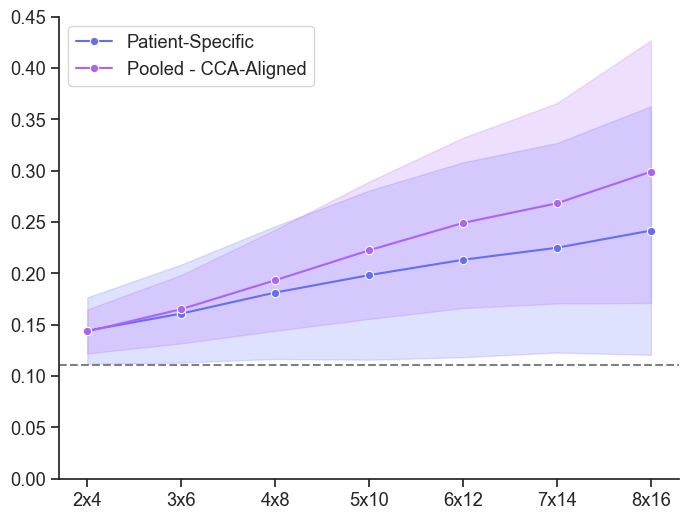

In [200]:
f, ax1 = plt.subplots(1,1, figsize=(8,6))

sns.lineplot(data=mean_grid_decode_df, x='Grid Size', y='Decoding Accuracy', hue='Decoding Context', marker='o', errorbar='sd', ax=ax1, palette=[px_colors[0], px_colors[3]])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axhline(1/9, color='grey', linestyle='--')
ax1.set_ylim(0.05, 0.45)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 0.45)

sns.despine()
plt.savefig(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\grid_subsamp_decode.svg")
plt.show()

### Panel c

#### Cross-patient correlation

In [80]:
all_pt_map_data = {pt: all_pt_dict[pt]['X1_map'] for pt in pt_names}

In [177]:
savg_corr_tot_df = pd.DataFrame()
for align_pt in pt_names:
# for align_pt in ['S14', 'S26']:
    print(f'##### Aligning to {align_pt} ({paper_pt_dict[align_pt]}) #####')
    
    align_pt_ind = pt_names.index(align_pt)
    other_pts = [pt for pt in pt_names if pt != align_pt]

    n_comp_corr = 10

    savg_corr_df = pd.DataFrame()

    savg_list = [8,7,6,5,4,3,2,1]
    # savg_list = [1]
    for cont_size in savg_list:
        print(f'Contact Size: {cont_size}')

        # subsample all patient data with poisson disk sampling
        all_pt_traces_sub = {}
        for pt in pt_names:
        # for pt in ['S14']:
            savg_idx = spatial_avg_channels(pt, cont_size, DATA_PATH)
            all_pt_traces_sub[pt] = spatial_avg_data(all_pt_map_data[pt], savg_idx)
            # print(all_pt_traces_sub[pt].shape)


        # setup CCA aligners for each condition and patient
        aligners_sub = {}
        for i, pt in enumerate(pt_names):
            if i == align_pt_ind:
                continue
            aligners_sub[pt] = AlignCCA()
            # aligners_all[pt] = AlignCCA()

        # get patient-specific latent dynamics with PCA on channels
        to_align_sub = [PCA(n_components=0.9).fit_transform(all_pt_traces_sub[pt].reshape(-1, all_pt_traces_sub[pt].shape[-1])) for pt in pt_names]
        to_align_sub = [to_align_sub[i].reshape(all_pt_traces_sub[pt].shape[0], all_pt_traces_sub[pt].shape[1], -1) for i, pt in enumerate(pt_names)]

        # align patient-specific latent dynamics
        aligned_data_sub = {}
        # aligned_data_all = {}

        # aligning all patients to a single patient's space, so the align patient's latent dynamics are un-transformed
        aligned_data_sub[pt_names[align_pt_ind]] = to_align_sub[align_pt_ind]
        # aligned_data_all[pt_names[align_pt_ind]] = to_align[align_pt_ind]
        for i, pt in enumerate(pt_names):
            if i == align_pt_ind:
                continue
            
            # align by phoneme sequence
            to_align_seqs = [all_pt_phon_seqs[pt_names[align_pt_ind]], all_pt_phon_seqs[pt]]
            aligners_sub[pt].fit(to_align_sub[align_pt_ind], to_align_sub[i], to_align_seqs[0], to_align_seqs[1])
            aligned_data_sub[pt] = aligners_sub[pt].transform(to_align_sub[i])

        # align_corrs_sub = pt_corr_multi(aligned_data_sub[align_pt], [aligned_data_sub[pt] for pt in other_pts], all_pt_phon_labels[align_pt], [all_pt_phon_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
        align_corrs_sub = pt_corr_multi(aligned_data_sub[align_pt], [aligned_data_sub[pt] for pt in other_pts], all_pt_artic_labels[align_pt], [all_pt_artic_labels[pt] for pt in other_pts], n_comp=n_comp_corr)
        
        corr = np.mean(np.array(align_corrs_sub))
        curr_savg_df = pd.DataFrame([{'Contact Size': f'{cont_size}x{cont_size}', 'Correlation': corr}])
        # corr = np.mean(np.array(align_corrs_sub), axis=1)
        # curr_savg_df = pd.DataFrame(list(zip([f'{cont_size}x{cont_size}']*len(corr), corr)), columns=['Contact Size', 'Correlation'])
        savg_corr_df = pd.concat([savg_corr_df, curr_savg_df], ignore_index=True)

    savg_corr_df['Patient'] = paper_pt_dict[align_pt]
    savg_corr_df = savg_corr_df[['Patient', 'Contact Size', 'Correlation']]
    savg_corr_tot_df = pd.concat([savg_corr_tot_df, savg_corr_df], ignore_index=True)

##### Aligning to S14 (S1) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S26 (S2) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S23 (S5) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S33 (S3) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S22 (S4) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S39 (S6) #####
Contact Size: 8
Contact Size: 7
Contact Size: 6
Contact Size: 5
Contact Size: 4
Contact Size: 3
Contact Size: 2
Contact Size: 1
##### Aligning to S58 (S7) #####
C

In [178]:
savg_corr_tot_df

,Patient,Contact Size,Correlation
0,S1,8x8,0.506295
1,S1,7x7,0.521220
2,S1,6x6,0.502379
3,S1,5x5,0.554335
4,S1,4x4,0.272545
...,...,...,...
59,S8,5x5,0.292132
60,S8,4x4,0.329386
61,S8,3x3,0.470349
62,S8,2x2,0.421130


In [179]:
mean_savg_corr_df = savg_corr_tot_df.groupby(['Patient', 'Contact Size']).mean().reset_index()
mean_savg_corr_df

,Patient,Contact Size,Correlation
0,S1,1x1,0.437180
1,S1,2x2,0.318316
2,S1,3x3,0.348501
3,S1,4x4,0.272545
4,S1,5x5,0.554335
...,...,...,...
59,S8,4x4,0.329386
60,S8,5x5,0.292132
61,S8,6x6,0.318461
62,S8,7x7,0.378442


In [196]:
med_savg_df = mean_savg_corr_df.groupby(['Patient', 'Contact Size']).median().reset_index()
# fig = px.line(med_savg_df, x='Contact Size', y="Correlation", width=800, height=500)
fig = px.line(mean_savg_corr_df, x='Contact Size', y="Correlation", color='Patient', width=700, height=500)
# fig.update_traces(mode='lines')
fig.add_traces(px.box(mean_savg_corr_df, x='Contact Size', y="Correlation").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.15,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Spatially-averaged cross-patient correlation',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='Contact Size',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    autorange='reversed',
    # tickvals=[0,1],
    # range=[-0.35, 1.35],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.025, 0.75]
)

fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\savg_corr.svg")
fig.show()

#### Cross-patient decoding

In [197]:
pt_list = ['S14', 'S22', 'S23', 'S26', 'S33', 'S39', 'S58', 'S62']

pInd_list = [-1]

savg_list = [8, 7, 6, 5, 4, 3, 2, 1]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        for cont_size in savg_list:
        
            p_tar = np.zeros((2, 50))
            p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'ptSpecific/{pt}/spatialAvg_subsampling/{pt}_{p_str}_spatialAvg{cont_size}_ptSpecific_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DECODE_PATH + f'pooled/S62_added/{pt}/spatialAvg_subsampling/cca/{pt}_{p_str}_spatialAvg{cont_size}_pooled_ccaAligned_rbf_noCV_20fold.pkl')[k] for k in ['y_true', 'y_pred']])
            decode_df = pd.DataFrame(p_tar.T, columns=['Patient-Specific', 'Pooled - CCA-Aligned'])

            wide_dfs.append(decode_df)
            decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='Decoding Accuracy')
            decode_df['Patient'] = paper_pt_dict[pt]
            decode_df['Phoneme Index'] = p_str
            decode_df['Contact Length'] = cont_size
            decode_df['Contact Size'] = f'{cont_size}x{cont_size}'
            cols = decode_df.columns.tolist()
            cols = cols[-2:] + cols[:-2]
            decode_df = decode_df[cols]
            long_dfs.append(decode_df)
savg_decode_df_wide = pd.concat(wide_dfs)
savg_decode_df_long = pd.concat(long_dfs)
savg_decode_df_long = savg_decode_df_long.sort_values(by=['Contact Length', 'Decoding Context'], ascending=[False, True])

In [198]:
savg_decode_df_long

,Contact Length,Contact Size,Decoding Context,Decoding Accuracy,Patient,Phoneme Index
0,8,8x8,Patient-Specific,0.236111,S1,pAll
1,8,8x8,Patient-Specific,0.236111,S1,pAll
2,8,8x8,Patient-Specific,0.250000,S1,pAll
3,8,8x8,Patient-Specific,0.250000,S1,pAll
4,8,8x8,Patient-Specific,0.231481,S1,pAll
...,...,...,...,...,...,...
95,1,1x1,Pooled - CCA-Aligned,0.340824,S8,pAll
96,1,1x1,Pooled - CCA-Aligned,0.335206,S8,pAll
97,1,1x1,Pooled - CCA-Aligned,0.320225,S8,pAll
98,1,1x1,Pooled - CCA-Aligned,0.323970,S8,pAll


In [204]:
mean_savg_decode_df = savg_decode_df_long.drop(columns=['Phoneme Index']).groupby(['Patient', 'Contact Size', 'Decoding Context'], sort=False).mean().reset_index()
mean_savg_decode_df

,Patient,Contact Size,Decoding Context,Contact Length,Decoding Accuracy
0,S1,8x8,Patient-Specific,8.0,0.247315
1,S4,8x8,Patient-Specific,8.0,0.113245
2,S5,8x8,Patient-Specific,8.0,0.124018
3,S2,8x8,Patient-Specific,8.0,0.182477
4,S3,8x8,Patient-Specific,8.0,0.140870
...,...,...,...,...,...
123,S2,1x1,Pooled - CCA-Aligned,1.0,0.441306
124,S3,1x1,Pooled - CCA-Aligned,1.0,0.503913
125,S6,1x1,Pooled - CCA-Aligned,1.0,0.122579
126,S7,1x1,Pooled - CCA-Aligned,1.0,0.173050


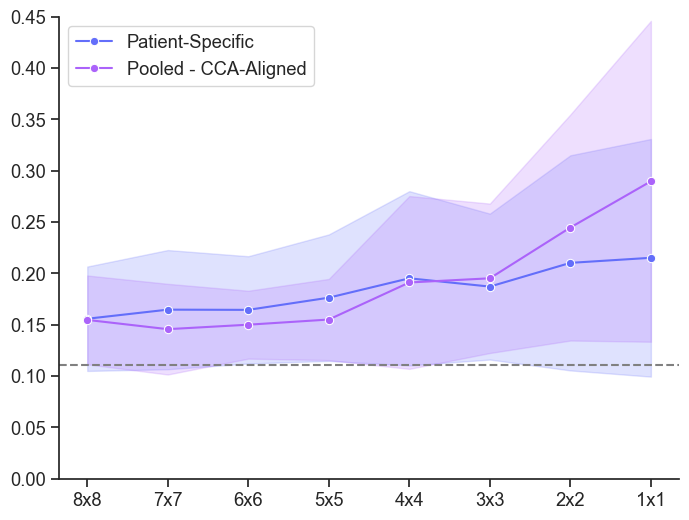

In [206]:
f, ax1 = plt.subplots(1,1, figsize=(8,6))

sns.lineplot(data=mean_savg_decode_df, x='Contact Size', y='Decoding Accuracy', hue='Decoding Context', marker='o', errorbar='sd', ax=ax1, palette=[px_colors[0], px_colors[3]])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axhline(1/9, color='grey', linestyle='--')
ax1.set_ylim(0.05, 0.45)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 0.45)

sns.despine()
plt.savefig(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_5\savg_decode.svg")
plt.show()